In [ ]:
import os
import json
import argparse
import pandas as pd
from pymongo import MongoClient
from reportparse.reader.base import BaseReader
from reportparse.annotator.base import BaseAnnotator
from reportparse.util.settings import LAYOUT_NAMES, LEVEL_NAMES
import matplotlib.pyplot as plt
import seaborn as sns
import argparse


# parser = argparse.ArgumentParser(description="Process and analyze climate-related text from a PDF.")
# parser.add_argument("--input", type=str, default="./reportparse/asset/example.pdf", help="Path to input PDF file.")
# parser.add_argument("--output", type=str, default="./cli_results", help="Directory to save output files.")

# args = parser.parse_args()
out= "./cli_results"
os.makedirs(out, exist_ok=True)
inp ="./reportparse/asset/example.pdf"

reader = BaseReader.by_name("pymupdf")()

document = reader.read(input_path=inp)

document = BaseAnnotator.by_name("climate")().annotate(document=document)
document = BaseAnnotator.by_name("climate_commitment")().annotate(document=document)
document = BaseAnnotator.by_name("climate_specificity")().annotate(document=document)

json_output_path = os.path.join(out, os.path.basename(inp) + ".json")
document.save(json_output_path)

df = document.to_dataframe(level="block")
df_2 = document.to_dataframe(level="page")

print(df)

# # eda
print(df.describe())
print()

print(df.info())
print()

print(df.head())
print()

print(df.tail())
print()

print(df.columns)
print()

print(df.index)
print()

climate_df = df[df["climate"] == "yes"]

cti_df = climate_df.groupby("page_id").apply(
    lambda x: pd.Series({
        "commit_total": (x["climate_commitment"] == "yes").sum(),
        "commit_non_spec": ((x["climate_commitment"] == "yes") & (x["climate_specificity"] == "non")).sum()
    })
)

# Calculate CTI
cti_df["CTI"] = cti_df["commit_non_spec"] / cti_df["commit_total"]
cti_df["CTI"].fillna(0, inplace=True)

cti_df.reset_index(inplace=True)

print(cti_df)

# for the whole document
total_commit = (climate_df["climate_commitment"] == "yes").sum()
total_commit_non_spec = ((climate_df["climate_commitment"] == "yes") & (climate_df["climate_specificity"] == "non")).sum()
overall_cti = total_commit_non_spec / total_commit if total_commit > 0 else 0

print(f"Overall Cheap Talk Index (CTI): {overall_cti:.4f}")

cti_results = {
    "page_cti_scores": cti_df.set_index("page_id")["CTI"].to_dict(),
    "overall_cti": overall_cti
}
input_base = os.path.basename(inp)
output_path = f"./cli_results/{input_base}_cti_scrores.json"

with open(output_path, "w") as f:
    json.dump(cti_results, f, indent=4)

print(f"CTI scores saved to {output_path}")


page_ids = list(cti_results["page_cti_scores"].keys())
page_scores = list(cti_results["page_cti_scores"].values())

plt.figure(figsize=(12, 6))

sns.barplot(x=page_ids, y=page_scores, palette="Blues_r")

plt.axhline(y=overall_cti, color='red', linestyle='--', label=f'Overall CTI: {overall_cti:.4f}')

plt.xlabel("Page ID")
plt.ylabel("CTI Score")
plt.title("Cheap Talk Index (CTI) per Page")
plt.xticks(rotation=90)  
plt.legend()

plt.tight_layout()
plt.show()

# save plot in the same dir
plt.savefig(f"./cli_results/{input_base}_cti_plot.png")


NameError: name 'args' is not defined

In [ ]:
from logging import getLogger
import traceback
import argparse
import os
import pandas as pd
import ollama
import chromadb
import requests
from reportparse.structure.document import Document
import re
from reportparse.db_rag.db import ChromaDBHandler
from langchain_groq import ChatGroq

logger = getLogger(__name__)


document = Document.from_json_file('example.pdf.json')
df = document.to_dataframe(level='page')
print(df)
print()
print(df.columns)

print()
# print first pass chroma result and web rag result for page 1
page_1 = document.pages[0]
# print(page_1.get_annotation("chroma"))
# print(page_1.get_annotation("web_rag"))

# print the same from df
# print(df.loc[0, "chroma_result"])

      page_id  page_num   page_width  page_height  \
0  page_idx_0         0  4405.499776  4405.499776   
1  page_idx_1         1  4405.499776  4405.499776   
2  page_idx_2         2  4405.499776  4405.499776   
3  page_idx_3         3  4405.499776  4405.499776   
4  page_idx_4         4  4405.499776  4405.499776   
5  page_idx_5         5  4405.499776  4405.499776   

                                           page_text  \
0  049 Hitachi Sustainability Report 2023 Environ...   
1  050 Hitachi Sustainability Report 2023 Environ...   
2  051 Hitachi Sustainability Report 2023 Environ...   
3  052 Hitachi Sustainability Report 2023 Environ...   
4  053 Hitachi Sustainability Report 2023 Environ...   
5  054 Hitachi Sustainability Report 2023 Environ...   

                                          First pass  \
0  Potential greenwashing claim: Hitachi's carbon...   
1  Potential greenwashing claim: Improve water us...   
2  Potential greenwashing claim: Achieving a Deca...   
3  Potentia

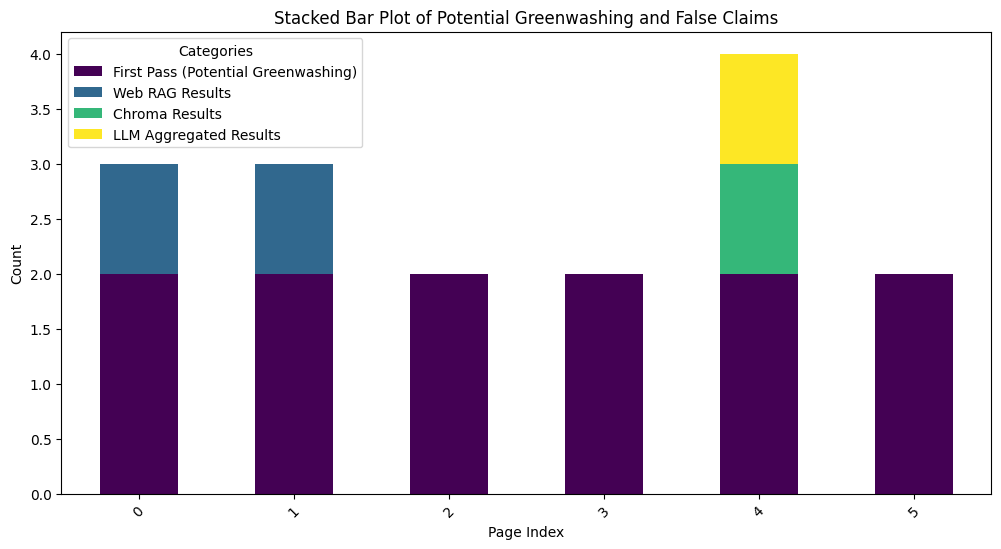

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import re

first_pass_count = df["First pass"].str.count("Potential greenwashing", flags=re.IGNORECASE).groupby(df.index).sum()

# Define function to count occurrences of "PARTIALLY FALSE" and "FALSE"
def count_false_statements(columns, df):
    return df[columns].apply(lambda col: col.str.contains("Result of the statement: PARTIALLY FALSE|Result of the statement: FALSE", na=False)).sum(axis=1)

web_rag_count = count_false_statements(["web_rag_result", "web_rag_result_2"], df)
chroma_count = count_false_statements(["chroma_result", "chroma_result_2"], df)
llm_agg_count = count_false_statements(["aggregator_result", "aggregator_result_2"], df)

plot_df = pd.DataFrame({
    "First Pass (Potential Greenwashing)": first_pass_count,
    "Web RAG Results": web_rag_count,
    "Chroma Results": chroma_count,
    "LLM Aggregated Results": llm_agg_count
})

ax = plot_df.plot(kind='bar', stacked=True, figsize=(12, 6), colormap='viridis')
plt.xlabel("Page Index")
plt.ylabel("Count")
plt.title("Stacked Bar Plot of Potential Greenwashing and False Claims")
plt.legend(title="Categories")
plt.xticks(np.arange(len(plot_df.index)), plot_df.index, rotation=45)
plt.show()
